In [116]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [88]:
os.listdir('data')

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## Load the data sets

In [89]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
cc_balance = pd.read_csv('data/credit_card_balance.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
pos_balance = pd.read_csv('data/POS_CASH_balance.csv')
previous_application = pd.read_csv('data/previous_application.csv')

Let's focus on the main application data for now and gain further insights:

## Exploratory Data Analysis

In [90]:
app_train.info()
app_train.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


float64    65
int64      41
object     16
dtype: int64

In [91]:
# Examine missing values:

def find_missing_values(df):
    missing_values_count = df.isnull().sum().sort_values(ascending=False)
    missing_values_count = missing_values_count[missing_values_count.iloc[:] != 0]
    missing_values_percent = ((missing_values_count/len(df))*100).round(1)
    missing_values = pd.concat([missing_values_count,missing_values_percent],axis=1,keys=['Count','Percent'])
    print('There are {} columns missing values'.format(missing_values_count.shape[0]))
    return(missing_values)

In [92]:
find_missing_values(app_train).head(20)

There are 67 columns missing values


,Count,Percent
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Later we should come up with a way to immute these values

Lets look at the categorical features

In [8]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encoding categorical features:

In [9]:
# Label encoding for features with 2 categories, one-hot encoding for features with more than two categories

label_encoder = preprocessing.LabelEncoder()
lecount = 0
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            label_encoder.fit(app_train[col])

            app_train[col] = label_encoder.transform(app_train[col])
            app_test[col] = label_encoder.transform(app_test[col])

            lecount += 1

In [10]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [11]:
targets = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = targets

print(app_train.shape)
print(app_test.shape)

(307511, 240)
(48744, 239)


### Examining features of interest
Let's take a closer look at some features that might help us understand the trend:
* Loan Information - AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE
* Client's Age - DAYS_BIRTH
* Clent's Income - AMT_INCOME_TOTAL, NAME_INCOME_TYPE
* Client's Occupation - DAYS_EMPLOYED, OCCUPATION_TYPE, ORGANIZATION_TYPE
* Client's Social Info - FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, OWN_CAR_AGE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, 
* Cleint's Family Information - CNT_CHILDREN, NAME_FAMILY_STATUS, CNT_FAM_MEMBERS

Besides these, there are a lot of features which are looking at the client's housing specifically, application details and external data sources. We will investigate those as well.

In [151]:
# Lets set some visualization parameters:

titleStyle = {'fontsize': 20,
            'fontweight' : 1,
             'verticalalignment': 'baseline',
             'horizontalalignment': 'center'}

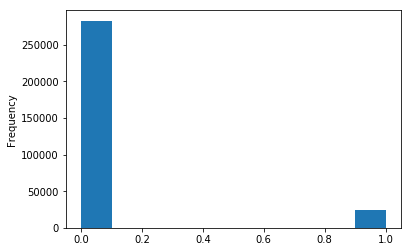

In [93]:
# Examining target label distribution:
app_train['TARGET'].plot.hist()

We seem to have a class imbalance problem. We need to weight the classes when we use a model.

#### Examining Loan features:

Let's examine the loan repayment in respect to the amount of credit due

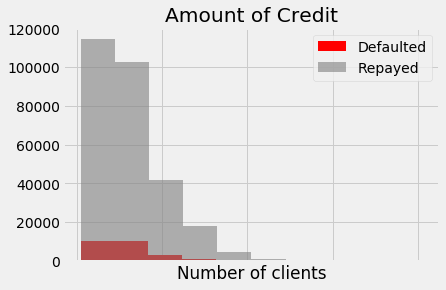

In [184]:
app_train['AMT_CREDIT'].loc[app_train['TARGET']==1].hist(color='red',alpha=1)
app_train['AMT_CREDIT'].loc[app_train['TARGET']==0].hist(color='gray',alpha=0.6)
plt.xlabel('Number of clients')
plt.title('Amount of Credit')
plt.tick_params(labelbottom='off')
plt.legend(loc='upper right',labels=['Defaulted','Repayed'])

#### Examining Client's Occupation

In [99]:
defaulters = app_train['OCCUPATION_TYPE'].loc[app_train['TARGET']==1].value_counts()
repaid = app_train['OCCUPATION_TYPE'].loc[app_train['TARGET']==0].value_counts()

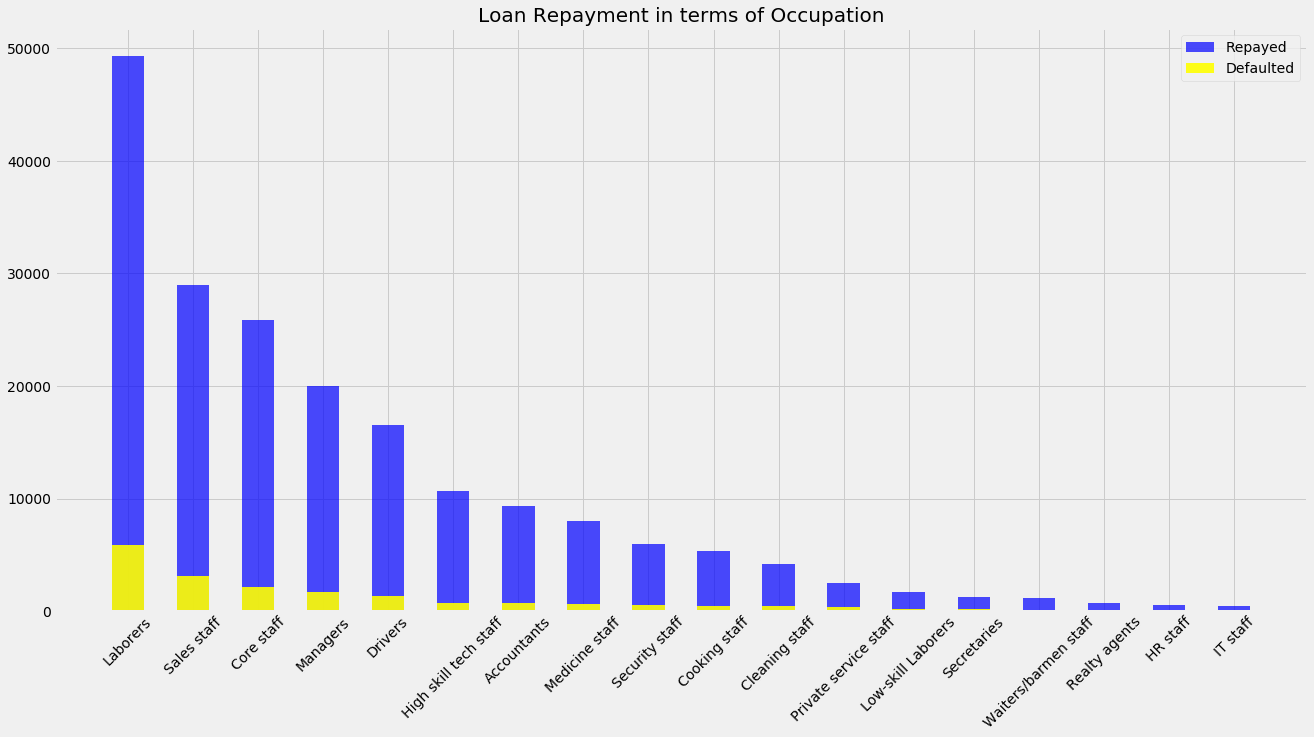

In [185]:
fig= plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,1,1)
width = 0.5
ind1 = np.arange(len(repaid.values))
ax.bar(ind1, repaid.values,width,color='blue',alpha=0.7)
ax.bar(ind1, defaulters.values,width,color='yellow',alpha=0.9)
ax.set_xticklabels(list(repaid.index),rotation=45)
ax.set_xticks(ind1)
ax.set_title('Loan Repayment in terms of Occupation',fontdict=titleStyle)
ax.legend(labels=['Repayed','Defaulted'])